# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [ ]:
!pip install pycaret

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [3]:
data = pd.read_feather('/content/credit_scoring.ftr')
data['mau'] = data.mau.astype('int64')
data = data.sample(50000)

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df_oot = data.copy().query("data_ref >= '2016-01-01'")
df = data.copy().query("data_ref < '2016-01-01'")

variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau']

In [5]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [6]:
metadados = pd.DataFrame(df[variaveis].dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.002754
posse_de_veiculo,object,0.0,2.0,covariavel,0.000170
posse_de_imovel,object,0.0,2.0,covariavel,0.008980
qtd_filhos,int64,0.0,8.0,covariavel,0.000504
tipo_renda,object,0.0,5.0,covariavel,inf
educacao,object,0.0,5.0,covariavel,0.014664
estado_civil,object,0.0,5.0,covariavel,0.001202
tipo_residencia,object,0.0,6.0,covariavel,0.007490
idade,int64,0.0,47.0,covariavel,0.011936
tempo_emprego,float64,6737.0,2943.0,covariavel,0.379000


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
df.groupby('data_ref').count()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,,
2015-01-01,3334,3334,3334,3334,3334,3334,3334,3334,3334,3334,2741,3334,3334,3334
2015-02-01,3237,3237,3237,3237,3237,3237,3237,3237,3237,3237,2693,3237,3237,3237
2015-03-01,3337,3337,3337,3337,3337,3337,3337,3337,3337,3337,2815,3337,3337,3337
2015-04-01,3350,3350,3350,3350,3350,3350,3350,3350,3350,3350,2767,3350,3350,3350
2015-05-01,3372,3372,3372,3372,3372,3372,3372,3372,3372,3372,2828,3372,3372,3372
2015-06-01,3376,3376,3376,3376,3376,3376,3376,3376,3376,3376,2793,3376,3376,3376
2015-07-01,3316,3316,3316,3316,3316,3316,3316,3316,3316,3316,2764,3316,3316,3316
2015-08-01,3382,3382,3382,3382,3382,3382,3382,3382,3382,3382,2785,3382,3382,3382
2015-09-01,3445,3445,3445,3445,3445,3445,3445,3445,3445,3445,2882,3445,3445,3445


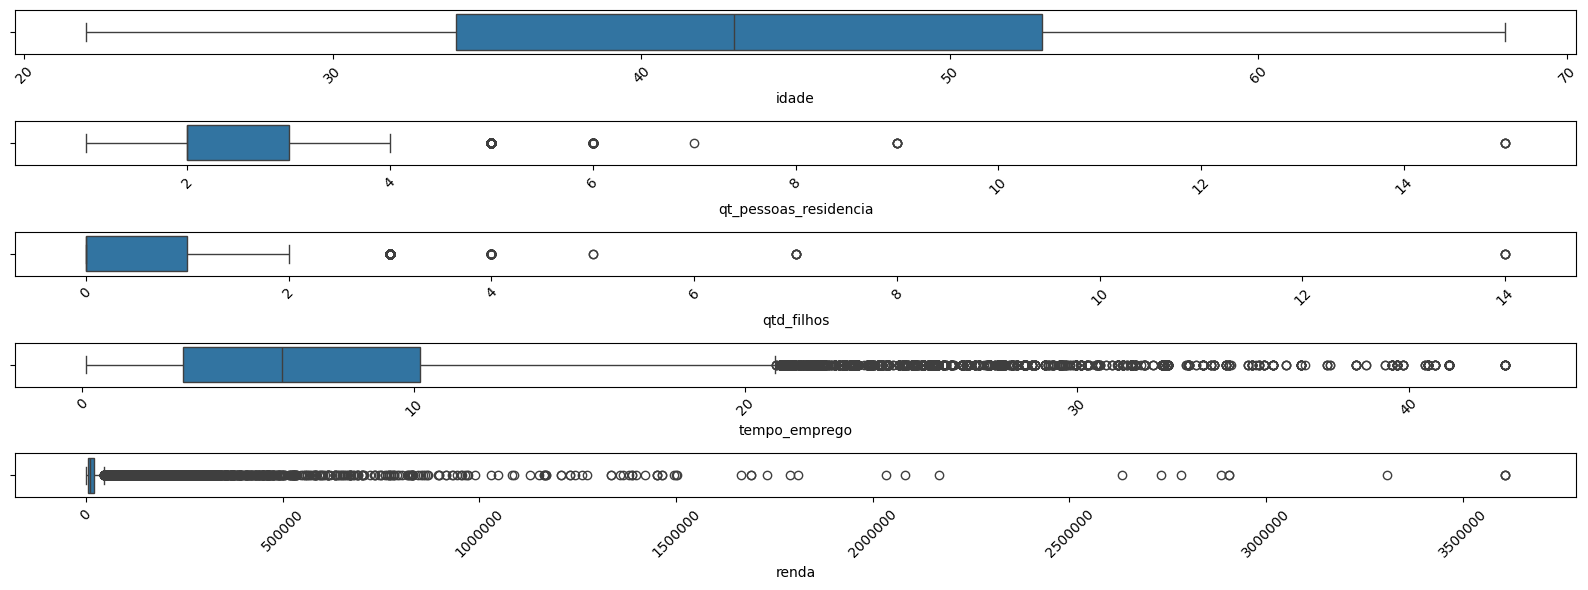

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 6))
continuas = ['idade', 'qt_pessoas_residencia', 'qtd_filhos', 'tempo_emprego', 'renda']

for i, var in enumerate(continuas):
    sns.boxplot(ax=axes[i], x=df[var])
    axes[i].ticklabel_format(style='plain', axis='x')  # Configura os números no formato "plain" (sem notação científica)
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)  # Rotaciona os ticks do eixo X se necessário

plt.tight_layout()
plt.show()

<Axes: xlabel='renda'>

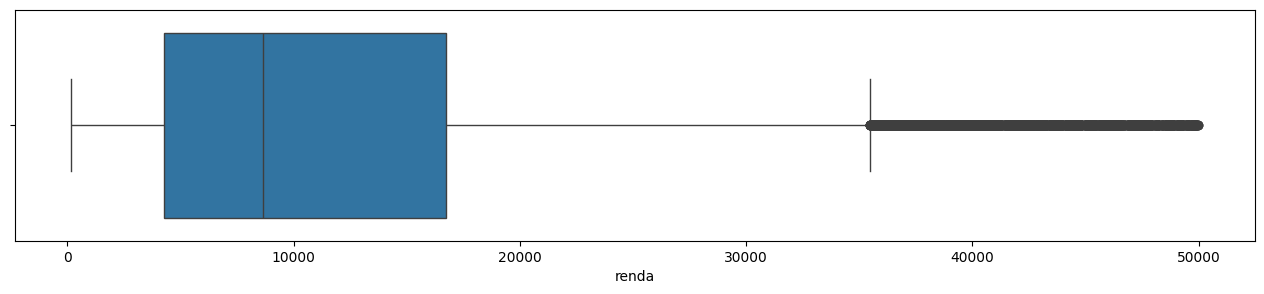

In [9]:
df = df.query('renda < 50000')
df_oot = df_oot.query('renda < 50000')

fig, ax = plt.subplots(figsize=(16, 3))
sns.boxplot(ax=ax, x=df['renda'])

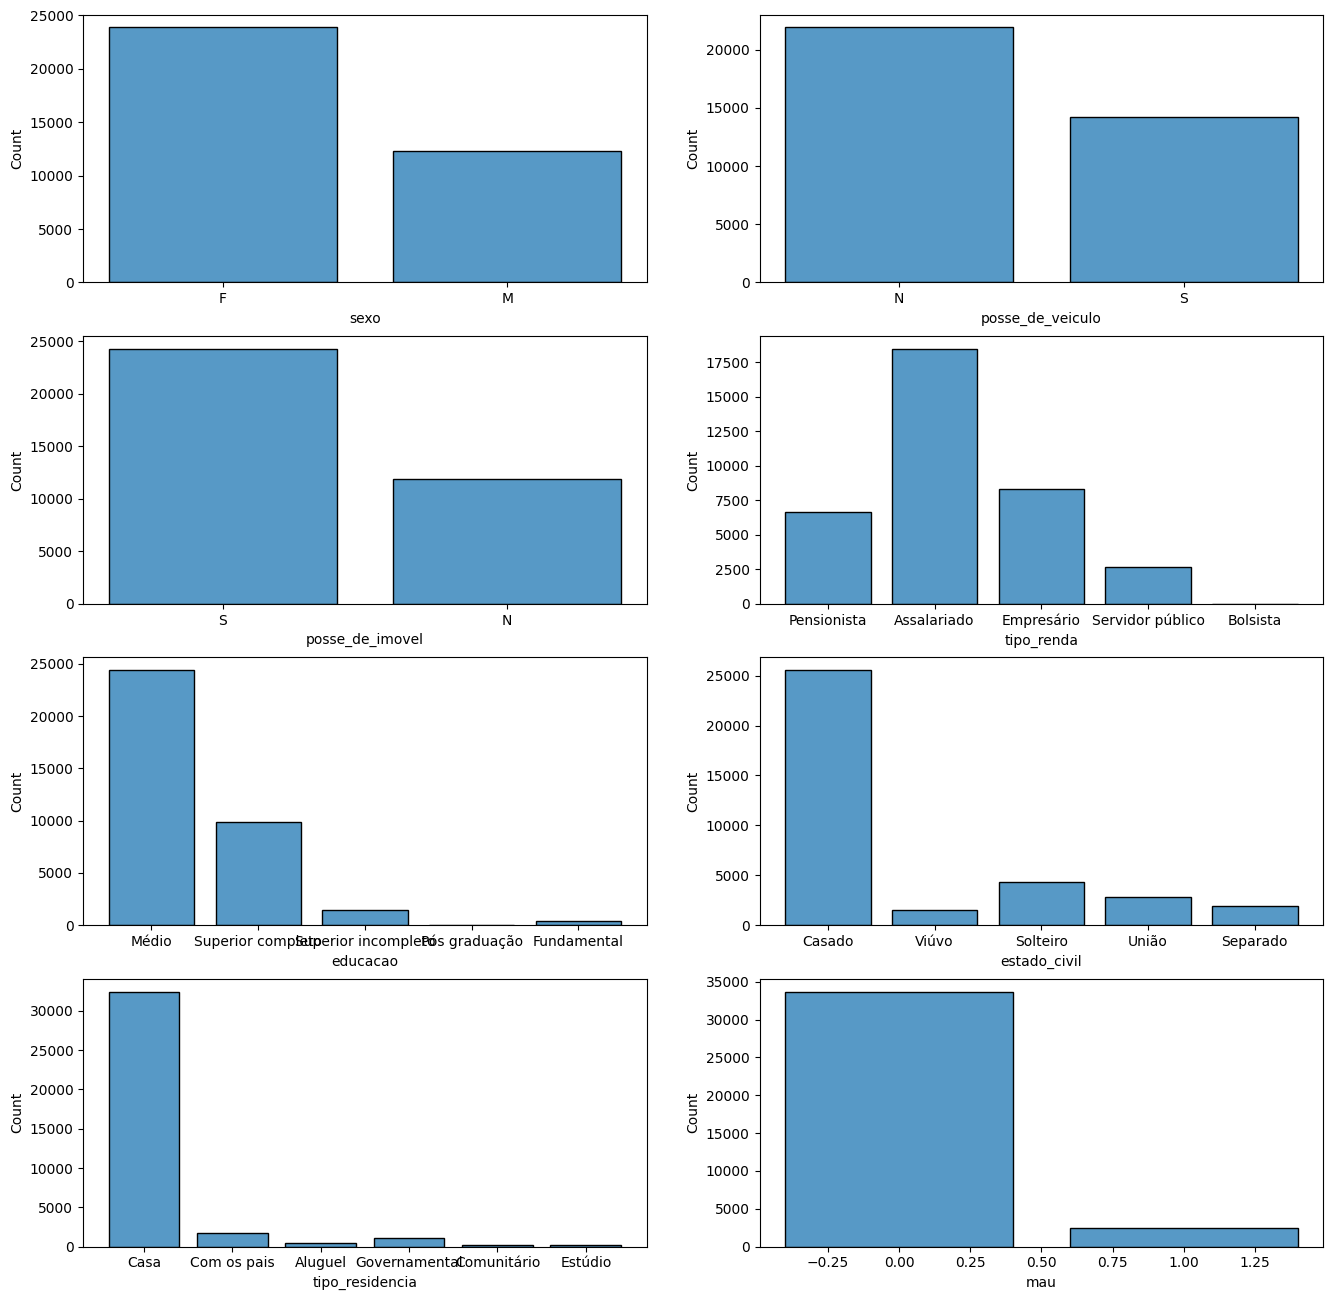

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
discretas = [var for var in variaveis if var not in continuas]


for i, var in enumerate(discretas):
    sns.histplot(ax=axes[i//2][i%2], x=df[var], binwidth=.5, discrete=True, shrink=.8)

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [11]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv.cont.plot.bar()

    return display(biv)


def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g[var].mean(),
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return display(biv)

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,22162,1727,0.072293,F,23889,0.001676,0.075577,0.069009,-2.551993,-2.504020,-2.602020,0.058397,0.106370,0.008370
M,11536,750,0.061045,M,12286,0.002160,0.065279,0.056811,-2.733155,-2.661579,-2.809532,-0.122764,-0.051189,-0.199141


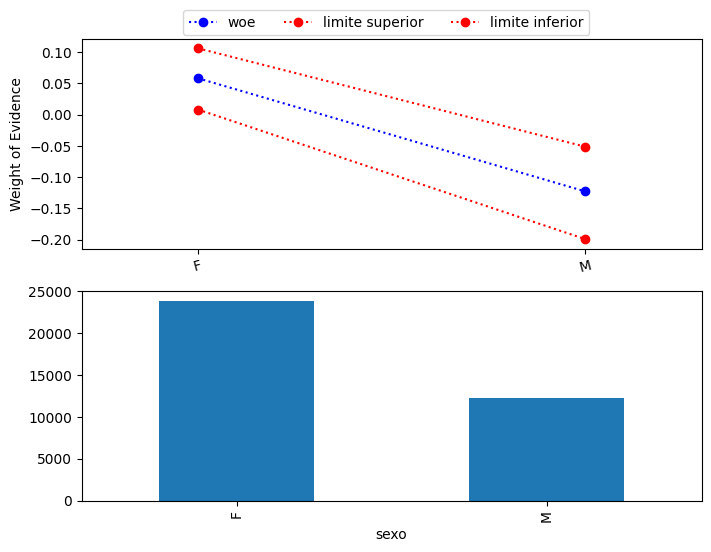

In [12]:
biv_discreta(discretas[0], df);

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,20389,1534,0.069972,N,21923,0.001723,0.073349,0.066595,-2.587117,-2.536345,-2.640207,0.023274,0.074045,-0.029817
S,13309,943,0.066166,S,14252,0.002082,0.070247,0.062085,-2.647129,-2.582894,-2.715158,-0.036739,0.027496,-0.104767


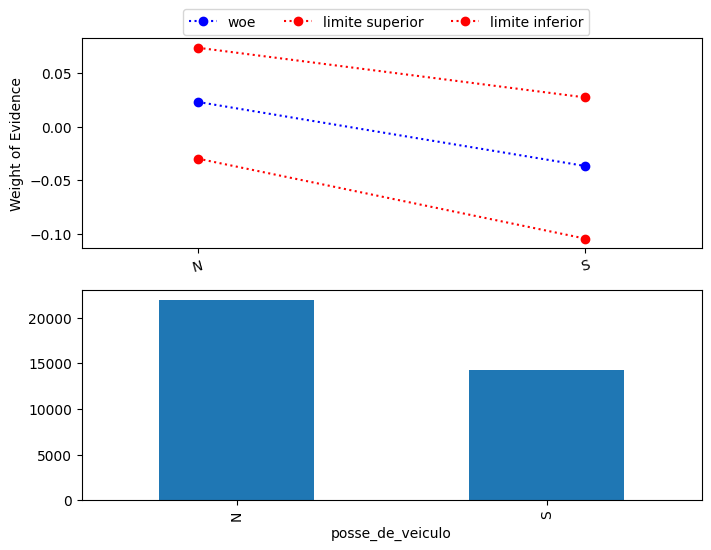

In [13]:
biv_discreta(discretas[1], df);

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,10968,912,0.076768,N,11880,0.002443,0.081555,0.071980,-2.487097,-2.421399,-2.556666,0.123293,0.188991,0.053725
S,22730,1565,0.064417,S,24295,0.001575,0.067504,0.061329,-2.675800,-2.625684,-2.728205,-0.065409,-0.015293,-0.117814


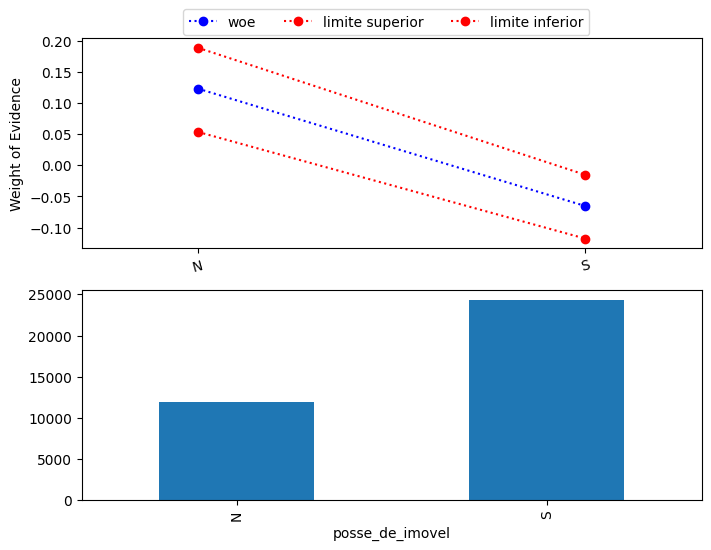

In [14]:
biv_discreta(discretas[2], df);

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,17170,1306,0.070686,Assalariado,18476,0.001886,0.074382,0.066990,-2.576195,-2.521245,-2.633866,0.034196,0.089146,-0.023476
Bolsista,12,0,0.000000,Bolsista,12,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
Empresário,7779,572,0.068495,Empresário,8351,0.002764,0.073913,0.063076,-2.610044,-2.528078,-2.698254,0.000346,0.082312,-0.087863
Pensionista,6189,448,0.067500,Pensionista,6637,0.003080,0.073537,0.061463,-2.625736,-2.533580,-2.725880,-0.015345,0.076810,-0.115489
Servidor público,2548,151,0.055947,Servidor público,2699,0.004424,0.064621,0.047272,-2.825784,-2.672416,-3.003400,-0.215394,-0.062025,-0.393010


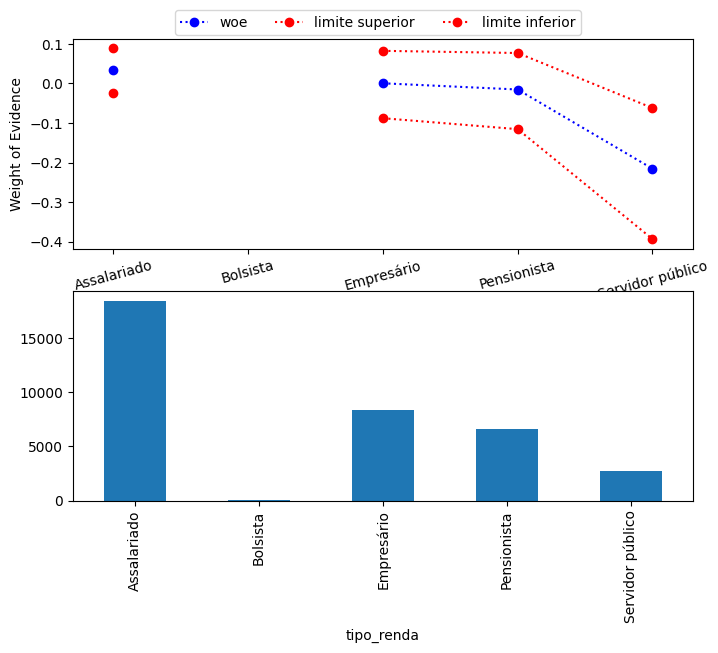

In [15]:
biv_discreta(discretas[3], df);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado/Bolsista,17182,1306,0.070640,Assalariado/Bolsista,18488,0.001884,0.074334,0.066947,-2.576893,-2.521945,-2.634564,0.033497,0.088446,-0.024173
Empresário,7779,572,0.068495,Empresário,8351,0.002764,0.073913,0.063076,-2.610044,-2.528078,-2.698254,0.000346,0.082312,-0.087863
Pensionista,6189,448,0.067500,Pensionista,6637,0.003080,0.073537,0.061463,-2.625736,-2.533580,-2.725880,-0.015345,0.076810,-0.115489
Servidor público,2548,151,0.055947,Servidor público,2699,0.004424,0.064621,0.047272,-2.825784,-2.672416,-3.003400,-0.215394,-0.062025,-0.393010


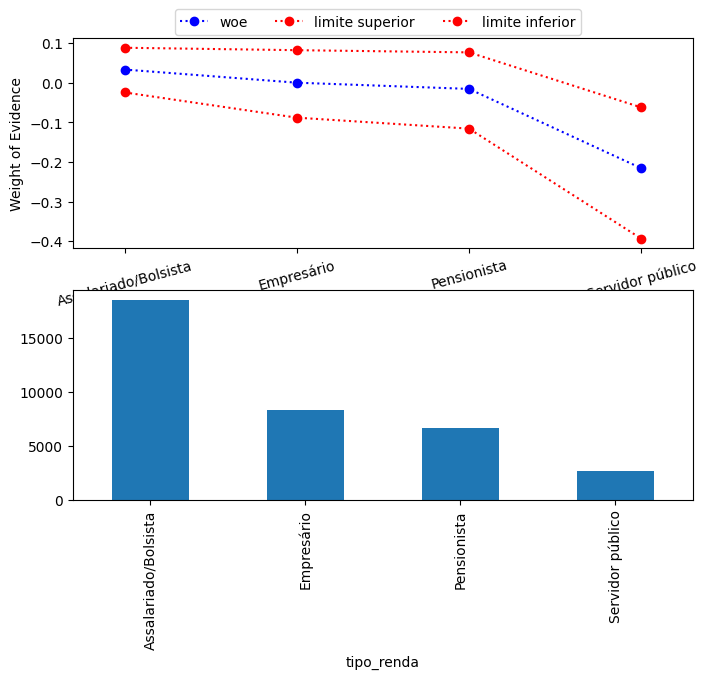

In [16]:
df2 = df.copy()
df_oot2 = df_oot.copy()
df2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista', 'Bolsista': 'Assalariado/Bolsista'}, inplace=True)
df_oot2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista', 'Bolsista': 'Assalariado/Bolsista'}, inplace=True)
biv_discreta('tipo_renda', df2)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,388,30,0.071770,Fundamental,418,0.012624,0.096586,0.046955,-2.559808,-2.235749,-3.010475,0.050582,0.374641,-0.400085
Médio,22623,1787,0.073208,Médio,24410,0.001667,0.076476,0.069940,-2.538429,-2.491227,-2.587613,0.071961,0.119163,0.022777
Pós graduação,43,1,0.022727,Pós graduação,44,0.022468,0.068037,-0.022583,-3.761200,-2.617236,NaN,-1.150810,-0.006846,NaN
Superior completo,9271,560,0.056963,Superior completo,9831,0.002338,0.061545,0.052381,-2.806710,-2.724471,-2.895417,-0.196319,-0.114080,-0.285026
Superior incompleto,1373,99,0.067255,Superior incompleto,1472,0.006528,0.080061,0.054450,-2.629634,-2.441519,-2.854485,-0.019243,0.168871,-0.244095


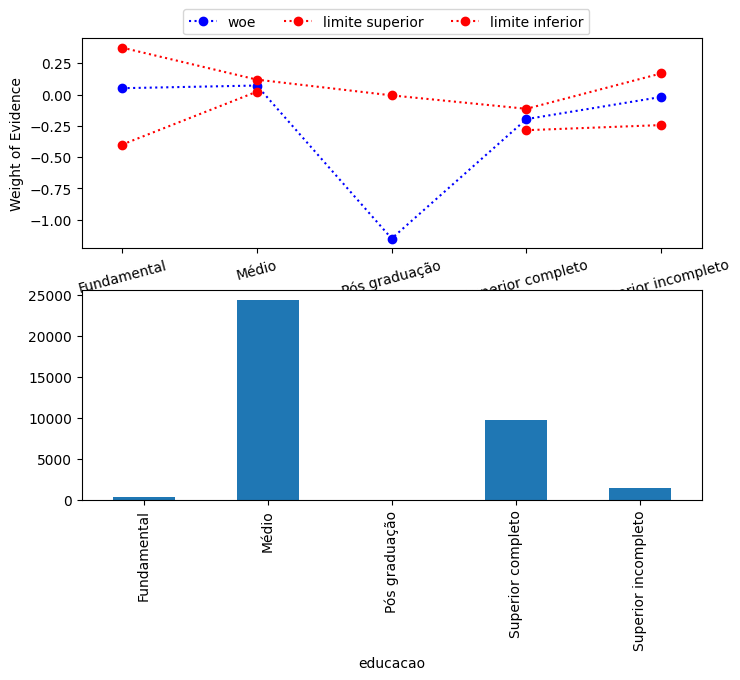

In [17]:
biv_discreta(discretas[4], df);

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental/Médio,23011,1817,0.073184,Fundamental/Médio,24828,0.001653,0.076423,0.069944,-2.538786,-2.491968,-2.587553,0.071605,0.118422,0.022838
Superior,10687,660,0.058165,Superior,11347,0.002197,0.062472,0.053858,-2.784543,-2.708526,-2.866038,-0.174153,-0.098136,-0.255648


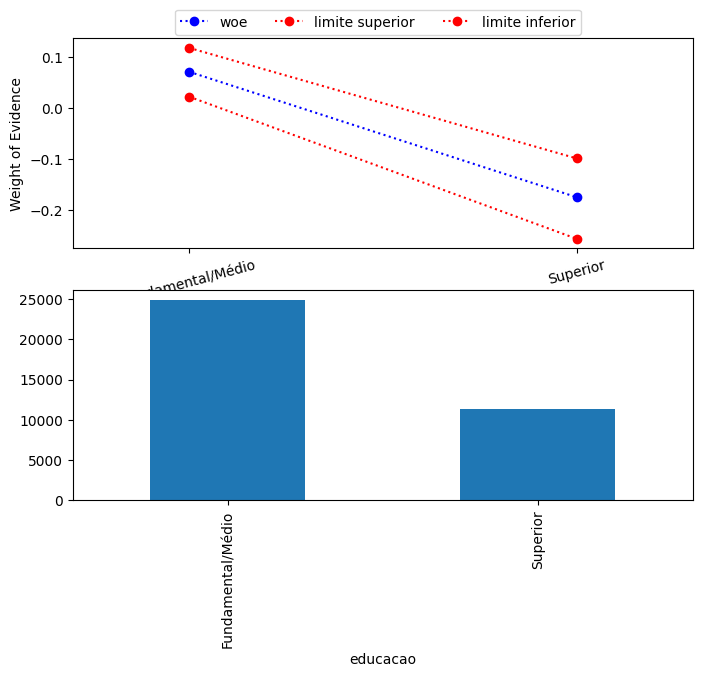

In [18]:
df2.educacao.replace({'Fundamental': 'Fundamental/Médio', 'Médio': 'Fundamental/Médio'}, inplace=True)
df2.educacao.replace({'Pós graduação': 'Superior', 'Superior completo': 'Superior', 'Superior incompleto': 'Superior'}, inplace=True)
df_oot2.educacao.replace({'Fundamental': 'Fundamental/Médio', 'Médio': 'Fundamental/Médio'}, inplace=True)
df_oot2.educacao.replace({'Pós graduação': 'Superior', 'Superior completo': 'Superior', 'Superior incompleto': 'Superior'}, inplace=True)
biv_discreta('educacao', df2)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,23843,1714,0.067066,Casado,25557,0.001565,0.070133,0.063999,-2.632661,-2.584654,-2.682750,-0.022271,0.025736,-0.072360
Separado,1813,149,0.075943,Separado,1962,0.005981,0.087672,0.064214,-2.498792,-2.342398,-2.679166,0.111598,0.267992,-0.068776
Solteiro,4050,306,0.070248,Solteiro,4356,0.003872,0.077839,0.062656,-2.582887,-2.472072,-2.705383,0.027503,0.138319,-0.094992
União,2569,206,0.074234,União,2775,0.004976,0.083992,0.064476,-2.523396,-2.389301,-2.674809,0.086995,0.221089,-0.064419
Viúvo,1423,102,0.066885,Viúvo,1525,0.006397,0.079434,0.054337,-2.635550,-2.450066,-2.856685,-0.025159,0.160324,-0.246295


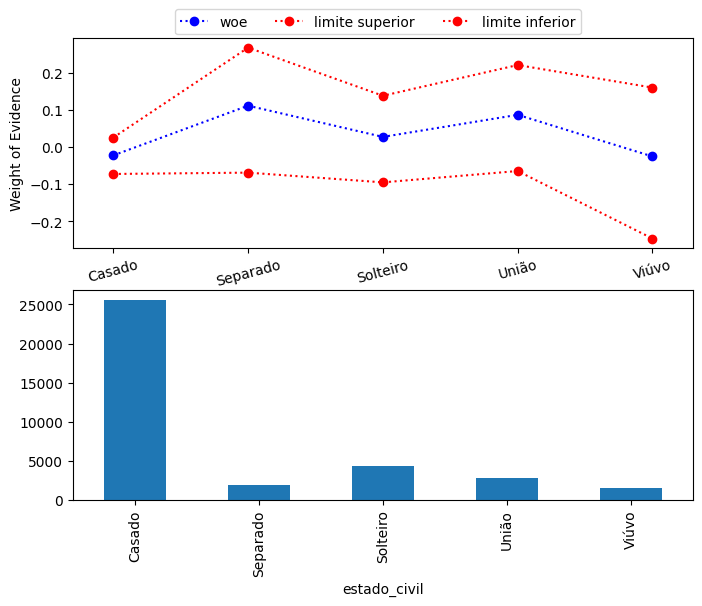

In [19]:
biv_discreta(discretas[5], df);

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,481,33,0.064202,Aluguel,514,0.010811,0.085443,0.042962,-2.679360,-2.370596,-3.103524,-0.068969,0.239794,-0.493134
Casa,30259,2201,0.067807,Casa,32460,0.001395,0.070542,0.065071,-2.620882,-2.578398,-2.664985,-0.010492,0.031992,-0.054595
Com os pais,1554,148,0.086957,Com os pais,1702,0.006830,0.100352,0.073561,-2.351375,-2.193314,-2.533240,0.259015,0.417076,0.077151
Comunitário,157,10,0.059880,Comunitário,167,0.018360,0.096130,0.023631,-2.753661,-2.240988,-3.721289,-0.143270,0.369402,-1.110898
Estúdio,227,9,0.038136,Estúdio,236,0.012467,0.062697,0.013574,-3.227725,-2.704690,-4.285933,-0.617335,-0.094299,-1.675542
Governamental,1020,76,0.069343,Governamental,1096,0.007673,0.084399,0.054287,-2.596825,-2.384020,-2.857660,0.013566,0.226370,-0.247269


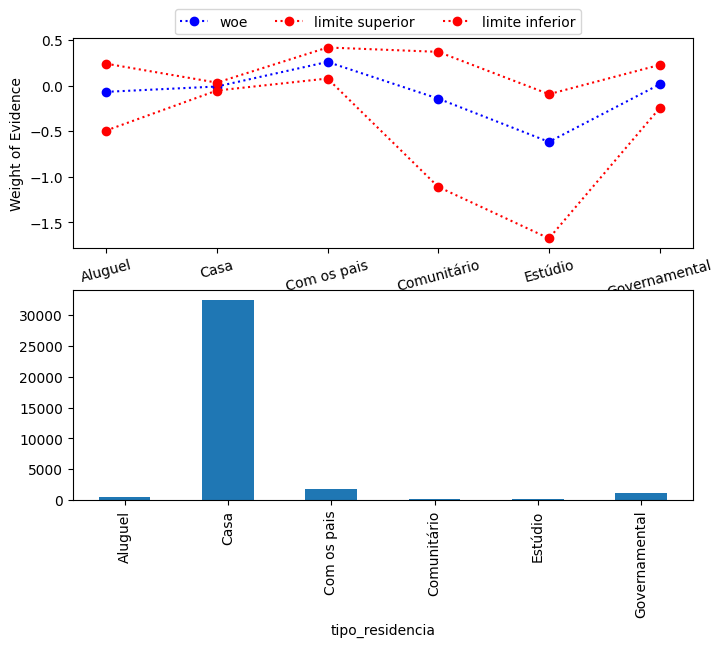

In [20]:
biv_discreta(discretas[6], df);

<ipython-input-11-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
idade,,,,,,,,,,,,,,
"(21.0, 32.0]",7086,585,0.076261,28.725851,7671,0.003030,0.082202,0.070321,-2.494264,-2.412802,-2.581772,0.116126,0.197588,0.028619
"(32.0, 39.0]",7046,473,0.062907,36.004921,7519,0.002800,0.068396,0.057418,-2.701120,-2.611591,-2.798256,-0.090730,-0.001201,-0.187866
"(39.0, 46.0]",6397,472,0.068715,42.856748,6869,0.003052,0.074698,0.062731,-2.606605,-2.516669,-2.704112,0.003785,0.093721,-0.093721
"(46.0, 55.0]",6578,478,0.067744,50.861395,7056,0.002992,0.073608,0.061879,-2.621875,-2.532537,-2.718697,-0.011485,0.077853,-0.108307
"(55.0, 68.0]",6591,469,0.066431,60.403541,7060,0.002964,0.072241,0.060621,-2.642858,-2.552770,-2.740585,-0.032467,0.057620,-0.130195


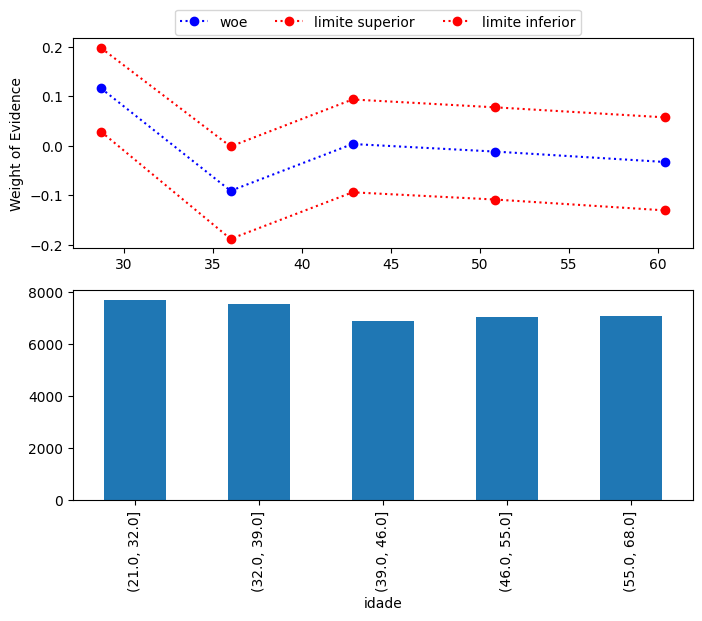

In [21]:
biv_continua(continuas[0], 5, df);

<ipython-input-11-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
"(0.0, 2.0]",24298,1804,0.069113,1.753314,26102,0.001570,0.072191,0.066036,-2.600388,-2.553515,-2.649234,0.010003,0.056876,-0.038844
"(2.0, 3.0]",5911,438,0.068987,3.000000,6349,0.003181,0.075222,0.062752,-2.602351,-2.509106,-2.703754,0.008039,0.101285,-0.093364
"(3.0, 4.0]",3042,195,0.060241,4.000000,3237,0.004182,0.068441,0.052041,-2.747271,-2.610894,-2.902272,-0.136881,-0.000504,-0.291882
"(4.0, 15.0]",447,40,0.082136,5.211499,487,0.012442,0.106582,0.057689,-2.413679,-2.126137,-2.793273,0.196711,0.484253,-0.182883


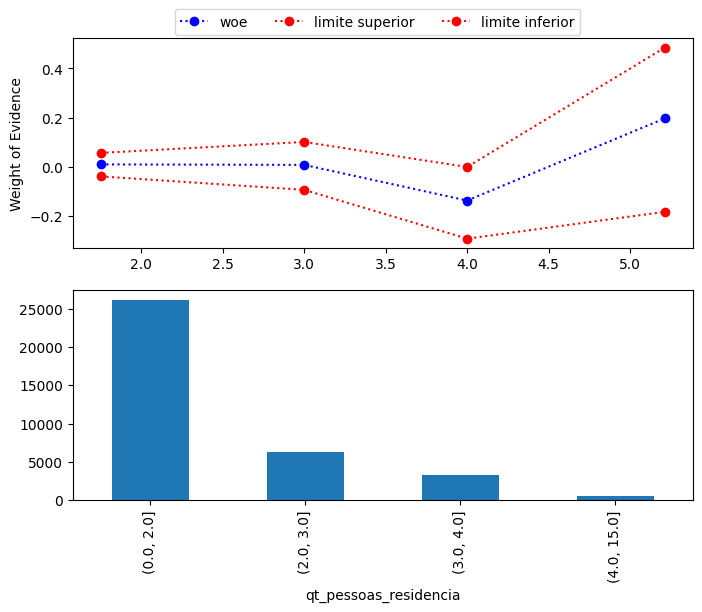

In [22]:
biv_continua(continuas[1], 12, df);

<ipython-input-11-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
"(-1.0, 1.0]",30057,2228,0.069010,0.229549,32285,0.001411,0.071775,0.066245,-2.601991,-2.559732,-2.645848,0.008399,0.050658,-0.035458
"(1.0, 2.0]",3174,208,0.061502,2.000000,3382,0.004131,0.069602,0.053402,-2.725210,-2.592820,-2.875022,-0.114819,0.017570,-0.264632
"(2.0, 14.0]",467,41,0.080709,3.212598,508,0.012085,0.104452,0.056965,-2.432757,-2.148709,-2.806659,0.177633,0.461682,-0.196269


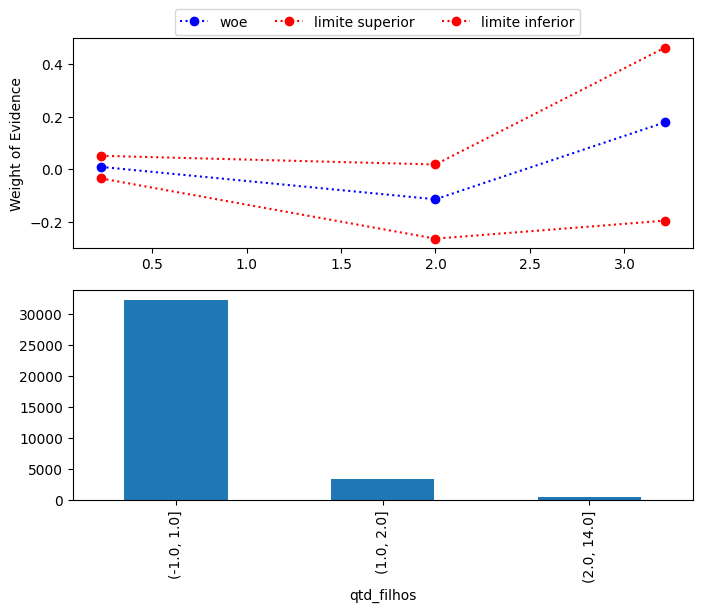

In [23]:
biv_continua(continuas[2], 10, df);

<ipython-input-11-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tempo_emprego,,,,,,,,,,,,,,
"(-1.0, 2.0]",5272,652,0.110061,1.116354,5924,0.004066,0.118032,0.102090,-2.090121,-2.011200,-2.174220,0.520270,0.599190,0.436170
"(2.0, 4.0]",5392,505,0.085637,3.207670,5897,0.003644,0.092780,0.078493,-2.368113,-2.280151,-2.462997,0.242277,0.330240,0.147393
"(4.0, 7.0]",5524,390,0.065945,5.315970,5914,0.003227,0.072272,0.059619,-2.650711,-2.552304,-2.758319,-0.040320,0.058087,-0.147928
"(7.0, 10.0]",5626,300,0.050624,7.935688,5926,0.002848,0.056207,0.045042,-2.931372,-2.820862,-3.054083,-0.320981,-0.210471,-0.443693
"(10.0, 34.0]",5709,182,0.030895,13.896447,5891,0.002254,0.035314,0.026475,-3.445792,-3.307522,-3.604718,-0.835402,-0.697131,-0.994328


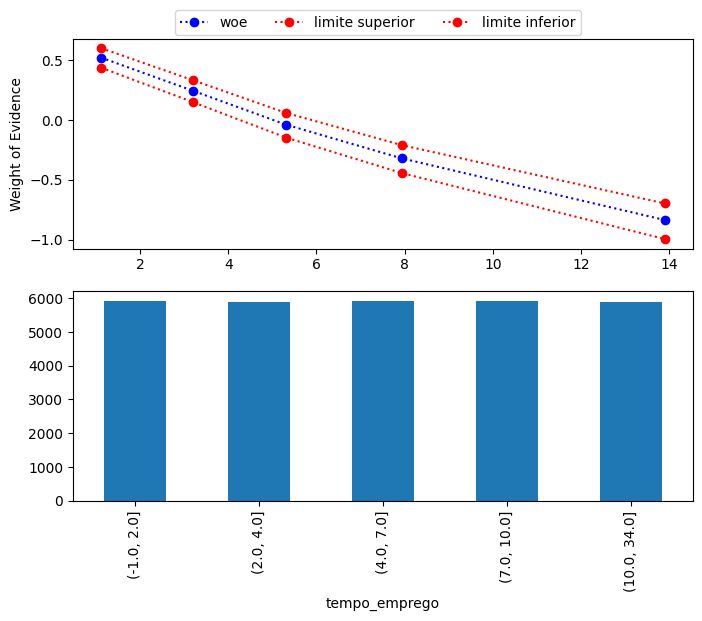

In [24]:
biv_continua(continuas[3], 5, df);

<ipython-input-11-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(173.0, 3607.0]",5978,1257,0.173739,2250.191657,7235,0.004454,0.182471,0.165007,-1.559358,-1.499697,-1.621436,1.051032,1.110693,0.988954
"(3607.0, 6652.0]",6652,583,0.080581,5063.843187,7235,0.003200,0.086853,0.074308,-2.434486,-2.352674,-2.522330,0.175905,0.257717,0.088061
"(6652.0, 11129.0]",6887,349,0.048231,8728.487948,7236,0.002519,0.053168,0.043294,-2.982319,-2.879655,-3.095491,-0.371929,-0.269265,-0.485100
"(11129.0, 19621.0]",7046,188,0.025988,14790.200958,7234,0.001871,0.029655,0.022321,-3.623773,-3.488010,-3.779633,-1.013383,-0.877619,-1.169242
"(19621.0, 49993.0]",7135,100,0.013822,30363.528285,7235,0.001373,0.016512,0.011131,-4.267597,-4.086995,-4.486825,-1.657207,-1.476605,-1.876435


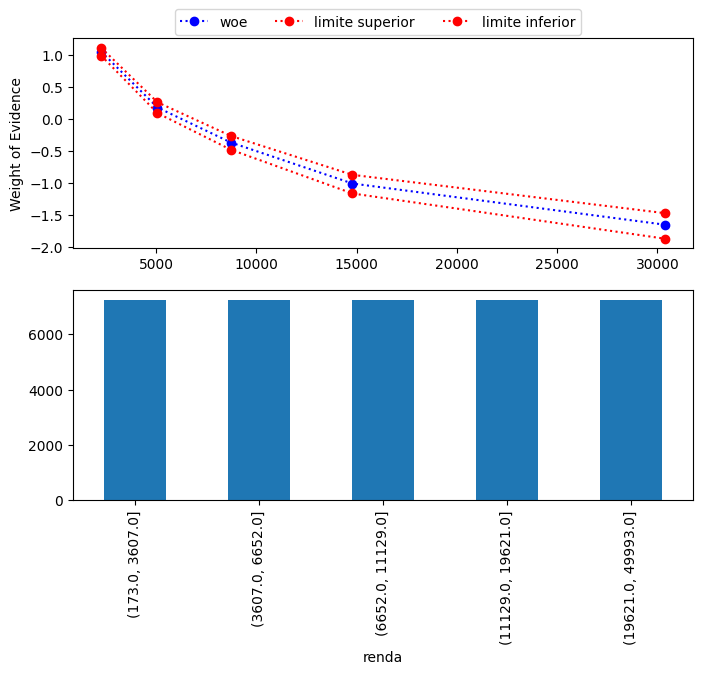

In [25]:
biv_continua(continuas[4], 5, df);

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [26]:
df2['tempo_emprego'] = df2['tempo_emprego'].fillna(df2['tempo_emprego'].mean())

In [27]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
tipo_renda,object,0.0,5.0,covariavel,inf
renda,float64,0.0,33408.0,covariavel,0.979487
tempo_emprego,float64,6737.0,2943.0,covariavel,0.379000
educacao,object,0.0,5.0,covariavel,0.014664
idade,int64,0.0,47.0,covariavel,0.011936
posse_de_imovel,object,0.0,2.0,covariavel,0.008980
tipo_residencia,object,0.0,6.0,covariavel,0.007490
sexo,object,0.0,2.0,covariavel,0.002754
estado_civil,object,0.0,5.0,covariavel,0.001202
qt_pessoas_residencia,float64,0.0,9.0,covariavel,0.000888


In [28]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
df2['tempo_emprego_norm'] = sc_X.fit_transform(df2[['tempo_emprego']])
df2['renda_norm'] = sc_X.fit_transform(df2[['renda']])
df_oot2['tempo_emprego_norm'] = sc_X.fit_transform(df_oot2[['tempo_emprego']])
df_oot2['renda_norm'] = sc_X.fit_transform(df_oot2[['renda']])

formula = 'mau ~ sexo + tipo_renda + tempo_emprego_norm + renda_norm'

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                36175
Model:                            GLM   Df Residuals:                    36168
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8214.6
Date:                Thu, 21 Nov 2024   Deviance:                       16429.
Time:                        18:43:34   Pearson chi2:                 7.16e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.04418
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -3.1373      0.047    -66.932      0.000      -3.229      -3.045
sexo[T.M]                         -0.0843      0.047     -1.784      0.074      -0.177       0.008
tipo_renda[T.Empresário]          -0.0069      0.053     -0.130      0.897      -0.111       0.097
tipo_renda[T.Pensionista]         -0.0335      0.060     -0.557      0.578      -0.151       0.084
tipo_renda[T.Servidor público]    -0.0267      0.091     -0.294      0.769      -0.205       0.152
tempo_emprego_norm                -0.0963      0.031     -3.141      0.002      -0.156      -0.036
renda_norm                        -1.4179      0.052    -27.328      0.000      -1.520      -1.316
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [29]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = rl.predict(df2[['sexo', 'tipo_renda', 'tempo_emprego_norm', 'renda_norm']])
y_test = df2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 93.15%
KS: 37.07% 
AUC: 75.05% 
GINI: 50.11%


In [30]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = rl.predict(df_oot2[['sexo', 'tipo_renda', 'tempo_emprego_norm', 'renda_norm']])
y_test = df_oot2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 84.65%
KS: 35.31% 
AUC: 73.45% 
GINI: 46.90%


## Criar um pipeline utilizando o sklearn pipeline

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.covariance import EllipticEnvelope

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [32]:
imputer = SimpleImputer(strategy='mean')

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [33]:
class EllipticEnvelopeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.1):
        self.contamination = contamination
        self.envelope = EllipticEnvelope(contamination=self.contamination, support_fraction=0.9)

    def fit(self, X, y=None):
        self.envelope.fit(X)
        return self

    def transform(self, X, y=None):
        return self.envelope.predict(X).reshape(-1, 1)

In [34]:
outliers_removal = EllipticEnvelopeTransformer(contamination=0.1)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [35]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [36]:
pca_pipe = PCA(n_components=5)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [37]:
dummies = OneHotEncoder(handle_unknown='ignore')

### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [38]:
numeric_features = continuas
categorical_features = discretas[:-1]

numeric_transformer = Pipeline(steps=[
    ('imputer', imputer),
    ('outliere_removal', outliers_removal),
])

categorical_transformer = Pipeline(steps=[
    ('dummy', dummies),
    ('feature_selector', feature_selector),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca_pipe),
                           ('log_reg', LogisticRegression(max_iter=200))
                          ])

pipe.fit(df2[variaveis].iloc[:,:-1], df2['mau'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outliere_removal',
                                                                   EllipticEnvelopeTransformer())]),
                                                  ['idade',
                                                   'qt_pessoas_residencia',
                                                   'qtd_filhos',
                                                   'tempo_emprego', 'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('dummy',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('feature_selector',
                                                                   SelectFromModel(estimator=RandomForestClassifier(random_state=42)))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia'])])),
                ('pca', PCA(n_components=5)),
                ('log_reg', LogisticRegression(max_iter=200))])

### Treinar um modelo de regressão logistica com o resultado

In [39]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = pipe.predict(df_oot2[variaveis].iloc[:,:-1])
y_test = df_oot2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 84.65%
KS: 0.00% 
AUC: 50.00% 
GINI: 0.00%


### Salvar o pickle file do modelo treinado

In [40]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(pipe, open(nome_arquivo, 'wb'))

# Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [41]:
from pycaret.classification import *
setup = setup(
    data = df,
    target = 'mau',
    numeric_imputation='mean',
    normalize=True,
    remove_outliers=True,
    pca=True,
    pca_components=5,
    normalize_method='zscore',
    transformation=True,
    transformation_method = 'quantile',
    fix_imbalance=True
)
models()

,Description,Value
0,Session id,7146
1,Target,mau
2,Target type,Binary
3,Original data shape,"(36175, 16)"
4,Transformed data shape,"(55897, 6)"
5,Transformed train set shape,"(45044, 6)"
6,Transformed test set shape,"(10853, 6)"
7,Numeric features,7
8,Date features,1
9,Categorical features,7


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [42]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8891,0.8795,0.6782,0.3440,0.4565,0.4020,0.4308
1,0.9080,0.8813,0.6724,0.3993,0.5011,0.4540,0.4728
2,0.8965,0.8791,0.6763,0.3622,0.4718,0.4202,0.4454
3,0.8922,0.8656,0.6590,0.3476,0.4551,0.4016,0.4270
4,0.8997,0.8817,0.6358,0.3654,0.4641,0.4132,0.4326
5,0.8957,0.9042,0.6763,0.3600,0.4699,0.4180,0.4436
6,0.9115,0.8917,0.6821,0.4111,0.5130,0.4677,0.4858
7,0.9072,0.8649,0.6301,0.3893,0.4812,0.4334,0.4486
8,0.8934,0.8713,0.6494,0.3509,0.4556,0.4023,0.4258


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [43]:
tuned_lightgbm = tune_model(lightgbm, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8792,0.8729,0.6264,0.3114,0.4160,0.3570,0.3843
1,0.8899,0.8721,0.6609,0.3433,0.4519,0.3974,0.4238
2,0.8807,0.8771,0.7052,0.3271,0.4469,0.3899,0.4263
3,0.8772,0.8547,0.6590,0.3115,0.4230,0.3640,0.3962
4,0.8870,0.8834,0.6127,0.3262,0.4257,0.3695,0.3921
5,0.8855,0.9011,0.6763,0.3333,0.4466,0.3908,0.4214
6,0.9017,0.8914,0.6879,0.3790,0.4887,0.4393,0.4633
7,0.8945,0.8628,0.6301,0.3494,0.4495,0.3964,0.4176
8,0.8870,0.8765,0.6552,0.3353,0.4436,0.3879,0.4150


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


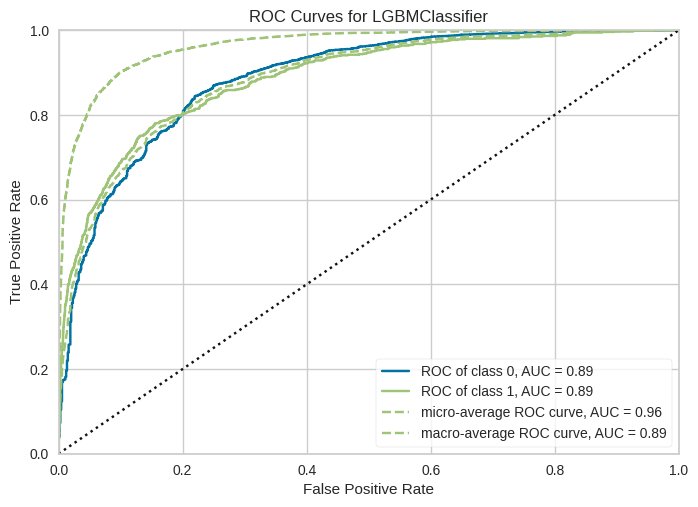

In [44]:
plot_model(tuned_lightgbm, plot = 'auc')

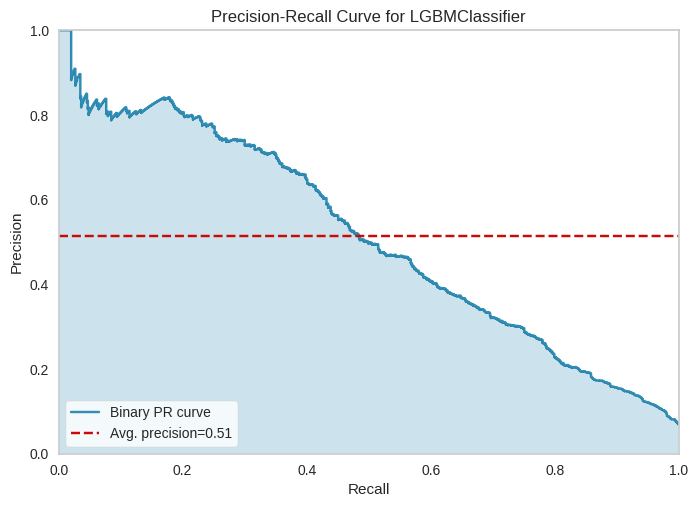

In [45]:
plot_model(tuned_lightgbm, plot = 'pr')

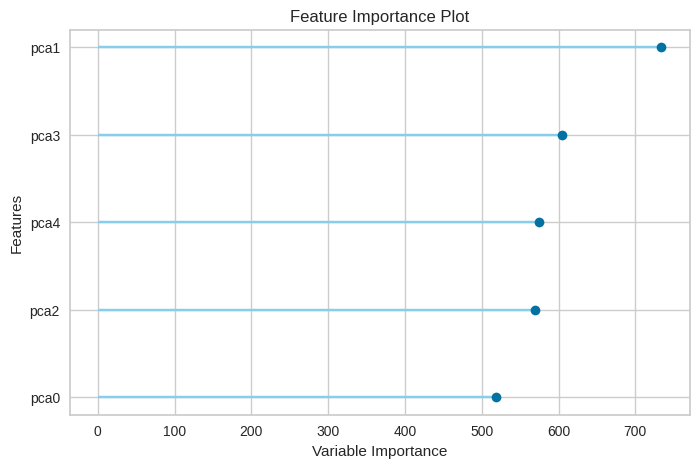

In [46]:
plot_model(tuned_lightgbm, plot = 'feature')

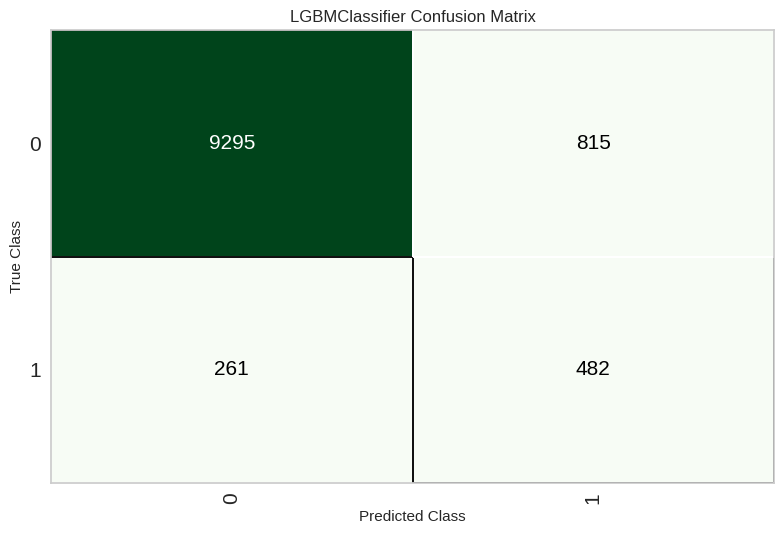

In [47]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [48]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9009,0.8866,0.6487,0.3716,0.4725,0.4223,0.4423


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,bom,mau,prediction_label,prediction_score
522566,2015-11-01,4677,F,S,N,0,Servidor público,Médio,União,Casa,45,19.534246,2.0,31696.720703,1,0,0,0.9065
234294,2015-05-01,15093,F,N,N,0,Assalariado,Médio,Casado,Casa,30,3.326027,2.0,8318.070312,1,0,0,0.9461
363152,2015-08-01,1838,F,N,S,0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,7955.160156,1,0,0,0.9879
430206,2015-09-01,756,F,N,S,0,Pensionista,Médio,Casado,Casa,65,NaN,2.0,11939.669922,1,0,0,0.9940
598860,2015-12-01,8790,M,N,S,1,Empresário,Médio,Separado,Casa,34,1.378082,2.0,2554.290039,1,0,1,0.6943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185562,2015-04-01,10662,M,S,S,0,Pensionista,Superior completo,Casado,Casa,65,NaN,2.0,7501.689941,1,0,0,0.9841
569805,2015-12-01,11762,M,N,S,0,Servidor público,Superior completo,Casado,Casa,26,6.158904,2.0,5672.049805,1,0,0,0.9967
448345,2015-09-01,3574,F,S,S,1,Pensionista,Médio,Casado,Casa,56,NaN,3.0,9310.690430,1,0,0,0.9550
226689,2015-05-01,2603,F,S,S,0,Empresário,Médio,Casado,Casa,40,3.895890,2.0,14262.610352,1,0,0,0.6522


In [49]:
final_lightgbm = finalize_model(tuned_lightgbm)
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda',
                                             'bom'],
                                    transform...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
            

In [50]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6763,0.7128,0.6904,0.1351,0.2260,0.1260,0.1937


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,bom,mau,prediction_label,prediction_score
522566,2015-11-01,4677,F,S,N,0,Servidor público,Médio,União,Casa,45,19.534246,2.0,31696.720703,1,0,0,0.6905
234294,2015-05-01,15093,F,N,N,0,Assalariado,Médio,Casado,Casa,30,3.326027,2.0,8318.070312,1,0,1,0.6344
363152,2015-08-01,1838,F,N,S,0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,7955.160156,1,0,0,0.9470
430206,2015-09-01,756,F,N,S,0,Pensionista,Médio,Casado,Casa,65,NaN,2.0,11939.669922,1,0,0,0.9700
598860,2015-12-01,8790,M,N,S,1,Empresário,Médio,Separado,Casa,34,1.378082,2.0,2554.290039,1,0,1,0.6996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185562,2015-04-01,10662,M,S,S,0,Pensionista,Superior completo,Casado,Casa,65,NaN,2.0,7501.689941,1,0,1,0.9233
569805,2015-12-01,11762,M,N,S,0,Servidor público,Superior completo,Casado,Casa,26,6.158904,2.0,5672.049805,1,0,1,0.9319
448345,2015-09-01,3574,F,S,S,1,Pensionista,Médio,Casado,Casa,56,NaN,3.0,9310.690430,1,0,1,0.6220
226689,2015-05-01,2603,F,S,S,0,Empresário,Médio,Casado,Casa,40,3.895890,2.0,14262.610352,1,0,0,0.6688


In [55]:
df_oot2.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'tempo_emprego_norm', 'renda_norm'],
      dtype='object')

In [59]:
df_oot2['bom'] = 1-df_oot2.mau
unseen_predictions = predict_model(lightgbm, data=df_oot2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7655,0.8699,0.8358,0.3800,0.5224,0.3947,0.4486


In [60]:
from pycaret.utils.generic import check_metric
check_metric(unseen_predictions['mau'], unseen_predictions['prediction_label'], metric = 'Accuracy')

0.7655

### Salvar o arquivo do modelo treinado

In [61]:
save_model(final_lightgbm,'pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda',
                                              'bom'],
                                     transform...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit
    - Subir um csv no streamlit
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos.
1. Enviar links do github para o tutor corrigir.